# 第二章 思维链和自我一致性

<div class="toc">
 <ul class="toc-item">
     <li><span><a href="#一、引言" data-toc-modified-id="一、引言">一、引言</a></span></li>
     <li>
         <span><a href="#二、CoT 提示方法与代码示例" data-toc-modified-id="二、CoT 提示方法与代码示例">二、CoT 提示方法与代码示例</a></span>
         <ul class="toc-item">
             <li><span><a href="##2.1 思维链提示过程" data-toc-modified-id="2.1 思维链提示过程">2.1 思维链提示过程</a></span></li>
             <li><span><a href="##2.2 零样本思维链" data-toc-modified-id="2.2 零样本思维链">2.2 零样本思维链</a></span></li>
             <li><span><a href="##2.3 自我一致性" data-toc-modified-id="2.3 自我一致性">2.3 自我一致性</a></span></li>
             </ul>
         </li>
     <li><span><a href="#三、总结与讨论" data-toc-modified-id="三、总结与讨论">三、总结与讨论</a></span></li>
     </ul>
</div>

## 一、引言
***

2021 年，**提示学习**（Prompt Learning）的研究浪潮兴起。而早在 2020 年，OpenAI 在 NeurIPS 2020 发表的一篇论文 [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165) 中就已经探讨了如何利用提示学习来提升大语言模型（Large Language Models, LLMs）的推理能力。论文中介绍了 Zero-shot、One-shot、Few-shot 三种不同的提示方法，如下图示意。

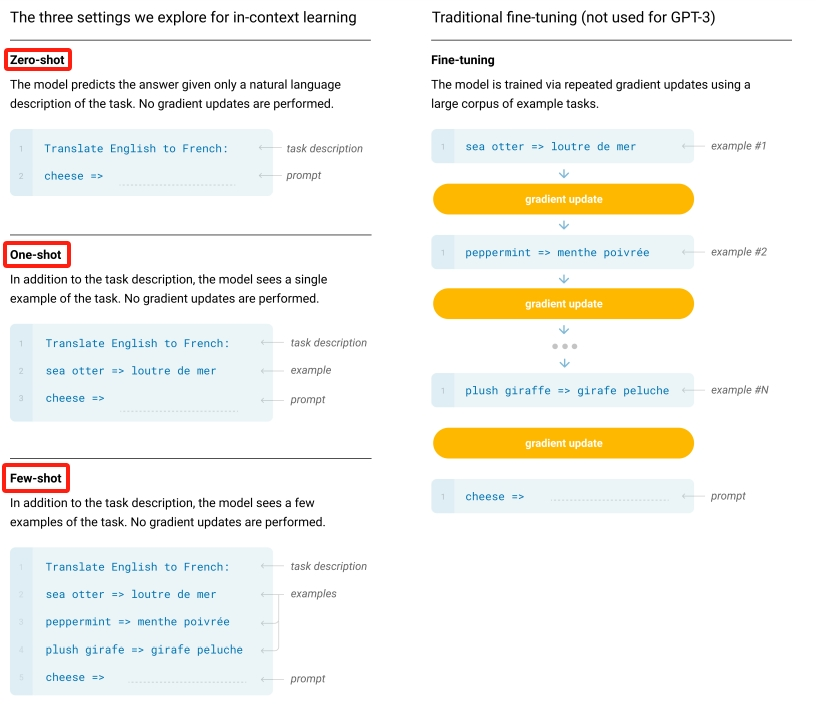

**在提示学习中，Zero-shot、One-shot 和 Few-shot 三者之间的差异为**：

- Zero-shot 学习指的是模型在没有看到任何具体示例的情况下，直接对未知类别进行分类或执行任务的能力。在这种情况下，模型仅依赖于其在训练过程中获得的知识和泛化能力。对于提示学习来说，**Zero-shot 场景通常意味着你会给模型一个任务描述或一个问题，但不提供任何具体的示例作为参考**。模型需要根据其先前的知识和理解来生成答案。

- One-shot 学习是指模型在看到一个（或每类一个）具体示例后，就能够执行某项任务或识别新类别的能力。这意味着模型通过观察单一实例就能够学习新概念或任务。在提示学习中，**这通常涉及到向模型展示一个示例**（包括问题和答案），然后立即要求它处理一个类似但不同的问题。这要求模型能够从极少量的数据中迅速学习并泛化。

- Few-shot 学习与 One-shot 学习类似，指的是模型在看到少量（通常是几个而非一个，但远少于传统机器学习项目中使用的样本数量）示例后执行任务的能力。**这种方法允许模型通过观察几个示例来更好地理解新任务或类别**。在提示学习框架下，**这意味着你会给模型提供几个相关问题及其答案作为示例**，然后让它处理新问题。

**小结**：Zero-shot、One-shot 和 Few-shot 学习代表了 LLM 处理未知任务时依赖已有知识量级的不同阶段。Zero-shot 依赖于模型的泛化能力；One-shot 要求模型能从单一实例中快速学习；而 Few-shot 则提供了稍微多一些的示例来帮助模型适应新任务。提示学习作为一种灵活的方法，在所有这三种情况下都非常有用，因为它允许研究人员以自然语言形式直接与模型交互，从而更容易地引导模型理解和执行新任务。

然而，即使是 Few-shot 提示方法，也存在一些缺陷。对于一些相对简单且无需逻辑推理的问题，LLM 可能通过检索其参数化知识来得出答案，从而表现出色。然而，**对于一些不太复杂但需要推理的问题**，例如简单的算术应用题，LLM 往往表现不佳。因此，**思维链（Chain-of-Thought，CoT）** 方法应运而生。

本章将详细阐述思维链提示、零样本思维链和自我一致性的基础理论。我们通过深入解析关键原理和提供实际代码示例，帮助读者全面理解和掌握思维链以及自我一致性的应用。阅读完本章后，读者将能够专业且准确地理解并应用思维链和自我一致性。

## 二、CoT 提示方法与代码示例
***
注意：我使用的测试环境是 Anaconda + Python 3.8.10。Python 的版本要求 Python 3.7+。

开始实验之前，我们需要安装好本次实验所需的第三方依赖库：`openai`。您可以通过运行以下命令来安装：`pip install openai==1.10.0`。OpenAI Python 库提供了一个便捷的途径，让任何 Python 3.7+ 应用程序可以访问 OpenAI REST API。



导入此次实验所需的依赖库

In [1]:
import os
from openai import OpenAI
from IPython.display import Markdown


# 从环境变量中获取 OpenAI API Key 或者直接赋值
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
OPENAI_API_KEY = "sk-...你的 OpenAI API Key"

# 如果您使用的是官方 API，就直接用 https://api.openai.com/v1 就行。
BASE_URL = "https://api.openai.com/v1"
# 如果您使用的不是官方 API，而是通过代理进行请求，请设置您的代理 URL。
# BASE_URL = "https://api.xxx.../v1"

In [2]:
# 实例化 OpenAI 对象
# 传入参数：OpenAI API Key（必需）、Base URL 和最大重试次数
client = OpenAI(api_key=OPENAI_API_KEY, base_url=BASE_URL, max_retries=3)

In [3]:
# 参数 n，整数或 Null，可选项，默认为 1。为每条输入信息生成多少个聊天完成选项。
# 参数 temperature，实数值或 Null，可选项，默认为 1。使用的采样温度，介于 0 和 2 之间。0.8 等较高值会使输出更加随机，而 0.2 等较低值会使输出更加集中和确定。

def get_completions(llm_prompt, model_endpoint):

    response = client.chat.completions.create(model=model_endpoint,
                                              messages=[
                                                        {"role": "user",
                                                         "content": llm_prompt
                                                        }
                                                       ],
                                              n=1, temperature=0, seed=42,
                                              presence_penalty=0, frequency_penalty=0,
                                              max_tokens=512
                                             )

    return response.choices[0].message.content.strip()

### 2.1 思维链提示过程

思维链（Chain-of-Thought，CoT）的本质是一种**离散式提示学习**。OpenAI 在 NeurIPS 2022 发表的一篇论文 [Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://openreview.net/forum?id=_VjQlMeSB_J) 探索了如何生成思维链：**一系列中间推理步骤**，显著提高了 LLM 执行复杂推理的能力。该论文特别展示了，通过一种称为 “**思维链提示**” 的简单方法，这种推理能力可以在足够大的语言模型中自然地出现。这种方法在提示中提供了一些**思维链的示例**，如下图示意：

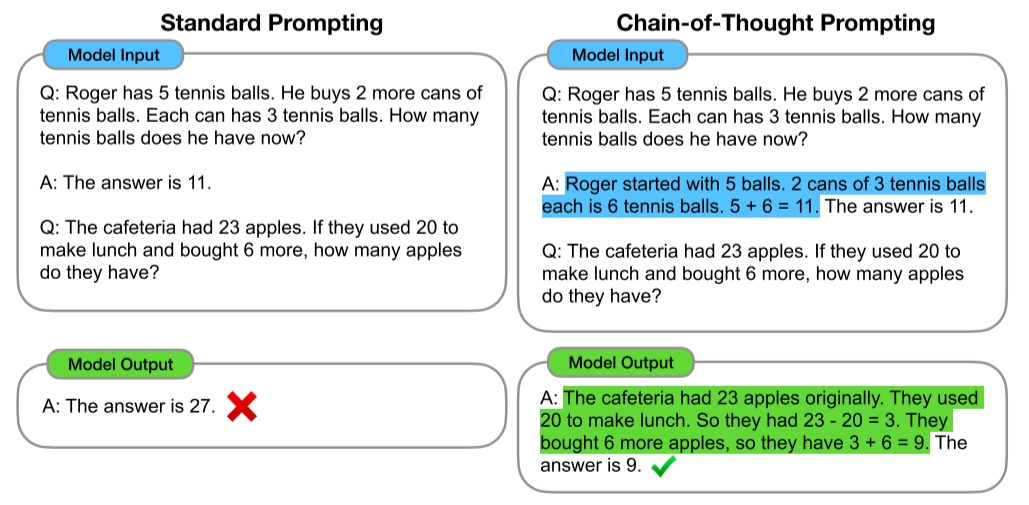

对于特定的任务，我们需要设计一到多个思维链的示例以进行思维链推理，这实际上是上下文学习的应用。如下图所示，这是一些算术、常识和符号推理基准测试的输入、思维链、输出三元组的示例。

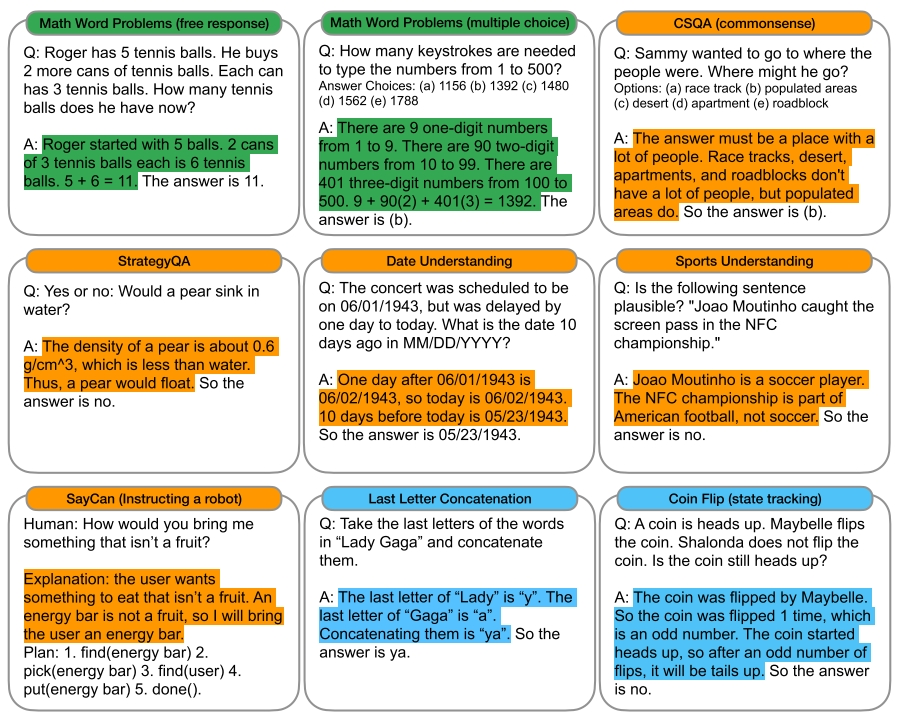

这里再提供 3 个简单的中文示例：

```
问：音乐会原定于 1943 年 6 月 1 日举行，但推迟了一天到今天。10 天前的日期（MM/DD/YYYY）是多少？
答：06/01/1943 后一天是 06/02/1943，所以今天是 06/02/1943。今天的前 10 天是 1943 年 5 月 23 日。所以答案是 05/23/1943。

问：输入 1 到 500 的数字需要击键多少次？答案选项：(a) 1156 (b) 1392 (c) 1480 (d) 1562 (e) 1788
答：1 到 9 有 9 个一位数。10 到 99 有 90 个两位数。100 到 500 有 401 个三位数。9 + 90(2) + 401(3) = 1392。答案是（b）。

问：把 "Lady Gaga" 中单词的最后一个字母连接起来。
答："Lady" 的最后一个字母是 "y"。"Gaga" 的最后一个字母是 "a"。连接起来就是 "ya"。所以答案是 "ya"。
```

思维链提示使 LLM 能够处理复杂的算术、常识和符号推理任务。在三个大语言模型（LLMs）上的实验结果表明，思维链提示可以显著提高这些任务的成绩。例如，在 GSM8K 数学单词问题基准测试中，仅用 8 个思维链示例提示 PaLM 540B，就达到了最先进的准确度，甚至超过了带有验证器的经过微调的 GPT-3。这种经验上的收获可能是惊人的。此外，模型通过思维链提示过程获得的性能提升可能与模型的大小成正比。

### 2.2 零样本思维链

Kojima 等人在 NeurIPS 2022 发表的一篇论文 [Large Language Models are Zero-Shot Reasoners](https://openreview.net/forum?id=e2TBb5y0yFf) 提出了零样本思维链（Zero-shot Chain of Thought，**Zero-shot-CoT**）提示是对上述的思维链提示的进一步研究，它引入了一种简洁的零样本提示方法。如下图所示，研究人员发现，通过在问题的结尾添加 "**Let's think step by step.**" 这个提示，**LLM 可以生成一个解答问题的思维链**。从这个思维链中，LLM 能够更准确地进行推理。

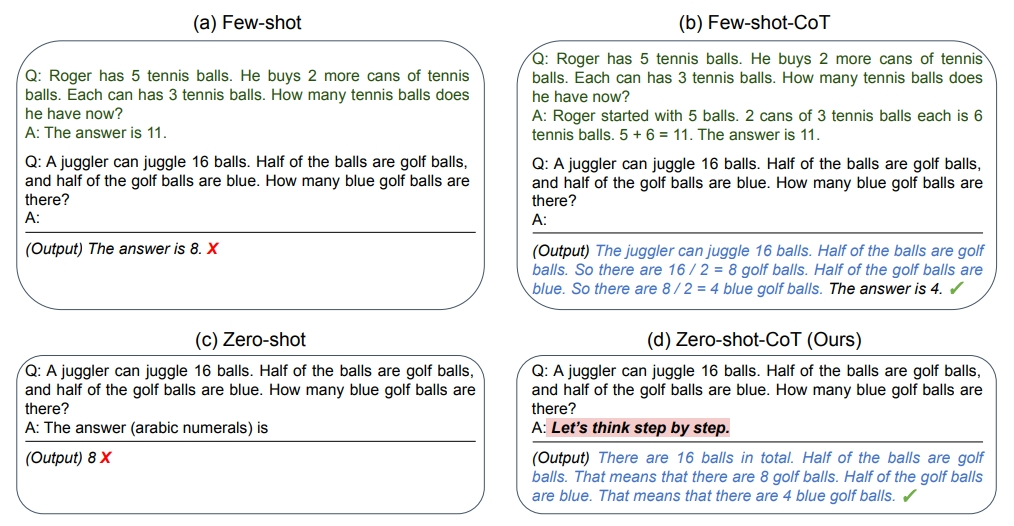

从技术角度看，完整的零样本思维链过程包含两个独立的提示${/}$补全结果。在下图中，左侧的顶部气泡形成了一个思维链，右侧的顶部气泡则接收了第一个提示（包括提示本身）的输出，并从思维链中抽取出答案。第二个提示是一个自我增强的提示。

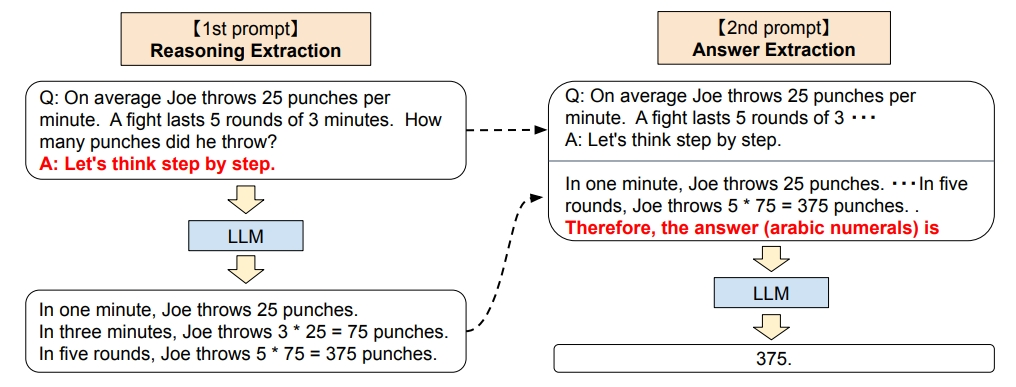


零样本思维链在改善算术、常识和符号推理任务的结果方面也表现出了有效性。然而，它有时候可能不如思维链提示过程那么有效。由于提取步骤通常需要针对特定任务，因此零样本思维链的泛化能力并不是那么强。Kojima 等人尝试了多种不同的零样本思维链提示，如 “让我们分步解决这个问题（Let's solve this problem by splitting it into steps.）” 或 “让我们从逻辑上思考一下（Let's think about this logically.）”，但他们发现 “让我们一步一步地思考（Let's think step by step.）” 对他们选定的任务最为有效。感兴趣的读者可以参阅论文中的实验分析。

因此，**当面临复杂问题或者难以获取思维链提示过程的示例时，零样本思维链可以发挥其作用。**

在问题后面加上 "**Let's think step by step.**" （让我们一步一步地思考。）这个提示可以自动激发思维链过程。

以一个算术问题为例，展示直接提问、带 1-shot 演示的思维链提示过程和零样本思维链的生成结果。

In [4]:
# 在 Python 中生成 Markdown 表格可以通过使用字符串拼接和格式化的方法来实现。
# 以下是一个用于生成 Markdown 表格的示例代码：
def generate_markdown_table(headers, rows):
    table = "| " + " | ".join(headers) + " |\n"
    table += "| " + " | ".join(["---"] * len(headers)) + " |\n"
    for row in rows:
        table += "| " + " | ".join(row) + " |\n"

    return table

In [5]:
llm = "gpt-3.5-turbo-0125"

# 直接提问
prompt1 = f"""问：输入 1 到 1200 的数字需要击键多少次？
答：
"""
# 带 1-shot 演示的思维链推理
prompt2 = f"""问：输入 1 到 500 的数字需要击键多少次？
答：1-9 之间有 9 个数字，每个数字按一次键，共需 9 次键。10-99 之间有 90 个数字，每个数字按两次键，共需 180 次键。100-500 之间有 401 个数字，每个数字按三次键，共需 1203 次键。将这些数字相加，得到总共需要按键的次数为 9 + 180 + 1203 = 1392 次。
问：输入 1 到 1200 的数字需要击键多少次？
答：
"""
# 零样本思维链推理
prompt3 = f"""问：输入 1 到 1200 的数字需要击键多少次？
答：让我们一步一步地思考。
"""

result1 = get_completions(prompt1, llm)
result2 = get_completions(prompt2, llm)
result_CoT = get_completions(prompt3, llm)
prompt_and_CoT = prompt3 + result_CoT + "所以，最终答案是："
result3 = get_completions(prompt_and_CoT, llm)

headers = ["直接提问 \u274c", "带 1-shot 演示的思维链推理 \u2705", "零样本思维链推理 \u2705"]
rows = [[result1.replace("\n", ""),
         result2.replace("\n", ""),
         result_CoT.replace("\n", "") + "所以，最终答案是：" + result3
        ],
        ]
markdown_table = generate_markdown_table(headers, rows)
display(Markdown(markdown_table))

| 直接提问 ❌ | 带 1-shot 演示的思维链推理 ✅ | 零样本思维链推理 ✅ |
| --- | --- | --- |
| 这个问题可以通过计算1到9、10到99、100到999和1000到1200这四个范围内数字的击键次数来得出答案。1到9的数字需要击键9次（1+2+3+4+5+6+7+8+9=45次）10到99的数字需要击键180次（10到19需要10次，20到29需要11次，以此类推，直到90到99需要20次，总共10*45=450次）100到999的数字需要击键2700次（100到199需要11次，200到299需要12次，以此类推，直到900到999需要20次，总共100*45=4500次）1000到1200的数字需要击键303次（1000到1099需要11次，1100到1199需要12次，1200需要4次，总共20*15+3=303次）所以，1到1200的数字需要击键总共为45+450+4500+303=5298次。 | 1-9 之间有 9 个数字，每个数字按一次键，共需 9 次键。10-99 之间有 90 个数字，每个数字按两次键，共需 180 次键。100-999 之间有 900 个数字，每个数字按三次键，共需 2700 次键。1000-1200 之间有 201 个数字，每个数字按四次键，共需 804 次键。将这些数字相加，得到总共需要按键的次数为 9 + 180 + 2700 + 804 = 3693 次。 | 首先，我们需要确定每个数字需要多少次击键。对于 1 到 9，每个数字只需要一次击键；对于 10 到 99，每个数字需要两次击键；对于 100 到 999，每个数字需要三次击键；对于 1000 到 1200，每个数字需要四次击键。接下来，我们计算每个范围内的数字数量：- 1 到 9 有 9 个数字- 10 到 99 有 90 个数字- 100 到 999 有 900 个数字- 1000 到 1200 有 201 个数字然后，我们计算每个范围内的总击键次数：- 1 到 9 需要 9 次击键- 10 到 99 需要 180 次击键- 100 到 999 需要 2700 次击键- 1000 到 1200 需要 804 次击键最后，将每个范围内的总击键次数相加：9 + 180 + 2700 + 804 = 3693所以，输入 1 到 1200 的数字需要击键 3693 次。所以，最终答案是：3693次。 |


中文 Prompt 输入：直接提问的推理过程有部分是错的，导致最终生成的答案不准确，产生了 “幻觉” 问题。带 1-shot 演示的思维链推理和零样本思维链推理的推理过程和生成答案都是正确的。

In [6]:
llm = "gpt-3.5-turbo-0125"

# 接下来是英文 Prompt

# 直接提问
prompt1 = f"""Q: How many keystrokes are needed to type the numbers from 1 to 1200?
A: 
"""
# 带 1-shot 演示的思维链推理
prompt2 = f"""Q: How many keystrokes are needed to type the numbers from 1 to 500?
A: To type the numbers from 1 to 9, we need 9 keystrokes (1, 2, 3, 4, 5, 6, 7, 8, 9). To type the numbers from 10 to 99, we need 90 * 2 keystrokes (10-99 = 90 numbers, each number requires 2 keystrokes). To type the numbers from 100 to 500, we need 401 * 3 keystrokes (100-500 = 401 numbers, each number requires 3 keystrokes). Adding all these up, we get: 9 + 90 * 2 + 401 * 3 = 1392 keystrokes.
Q: How many keystrokes are needed to type the numbers from 1 to 1200?
A: 
"""
# 零样本思维链推理
prompt3 = f"""Q: How many keystrokes are needed to type the numbers from 1 to 1200?
A: Let's think step by step. 
"""

result1 = get_completions(prompt1, llm)
result2 = get_completions(prompt2, llm)
result_CoT = get_completions(prompt3, llm)
prompt_and_CoT = prompt3 + result_CoT + "Therefore, the final answer is: "
result3 = get_completions(prompt_and_CoT, llm)

headers = ["直接提问 \u274c", "带 1-shot 演示的思维链推理 \u2705", "零样本思维链推理 \u274c"]
rows = [[result1.replace("\n", " "),
         result2.replace("\n", " "),
         result_CoT.replace("\n", " ") + " Therefore, the final answer is: " + result3
        ],
        ]
markdown_table = generate_markdown_table(headers, rows)
display(Markdown(markdown_table))

| 直接提问 ❌ | 带 1-shot 演示的思维链推理 ✅ | 零样本思维链推理 ❌ |
| --- | --- | --- |
| To type the numbers from 1 to 1200, you would need a total of 4680 keystrokes.   Here's the breakdown: - Numbers 1-9 require 9 keystrokes (1, 2, 3, 4, 5, 6, 7, 8, 9) - Numbers 10-99 require 180 keystrokes (10-99, each number requires 2 keystrokes) - Numbers 100-999 require 2700 keystrokes (100-999, each number requires 3 keystrokes) - Numbers 1000-1200 require 792 keystrokes (1000-1200, each number requires 4 keystrokes)  Adding all these up, you get a total of 4680 keystrokes. | To type the numbers from 1 to 9, we need 9 keystrokes.  To type the numbers from 10 to 99, we need 90 * 2 = 180 keystrokes.  To type the numbers from 100 to 999, we need 900 * 3 = 2700 keystrokes.  To type the numbers from 1000 to 1200, we need 201 * 4 = 804 keystrokes.  Adding all these up, we get: 9 + 180 + 2700 + 804 = 3693 keystrokes. | To type the numbers from 1 to 9, it would take 9 keystrokes (1, 2, 3, 4, 5, 6, 7, 8, 9).  To type the numbers from 10 to 99, it would take 180 keystrokes (10-99 = 90 numbers, each number requires 2 keystrokes).  To type the numbers from 100 to 999, it would take 2700 keystrokes (100-999 = 900 numbers, each number requires 3 keystrokes).  To type the numbers from 1000 to 1200, it would take 603 keystrokes (1000-1200 = 201 numbers, each number requires 4 keystrokes).  Adding all these up, we get: 9 + 180 + 2700 + 603 = 3492 keystrokes.  Therefore, it would take 3492 keystrokes to type the numbers from 1 to 1200. Therefore, the final answer is: 3492 keystrokes. |


英文 Prompt 输入：直接提问的推理过程有部分是错的，导致最终生成的答案不准确，产生了 “幻觉” 问题。零样本思维链推理的推理过程有部分是错的，导致最终生成的答案不准确，也产生了 “幻觉” 问题。零样本思维链推理差一点就能推理正确，只是有一处的推理是错的："To type the numbers from 1000 to 1200, it would take 603 keystrokes (1000-1200 = 201 numbers, each number requires 4 keystrokes)."。只有带 1-shot 演示的思维链推理的推理过程和生成答案是正确的。零样本思维链的泛化能力并不是那么强，有时候可能不如思维链提示过程那么有效。

此外，实践经验表明，**零样本思维链提示有时可以有效地增加生成内容的长度**。例如，我们可以考虑一个标准的提示：“数据科学与机器学习之间有什么联系？” 

如果在这个提示的末尾添加 “让我们一步一步地思考（Let's think step by step.）”，那么生成的补全结果可能会更长，而且质量可能会更好。代码示例和结果如下：

In [7]:
# 改造一下获得 Completions 的函数，实现返回消耗的 tokens 数量
def get_completions(system_instruction, llm_prompt, model_endpoint):

    response = client.chat.completions.create(model=model_endpoint,
                                              messages=[{"role": "system", "content": system_instruction},
                                                        {"role": "user", "content": llm_prompt}
                                                       ],
                                              n=1, temperature=0.30, seed=42,
                                              presence_penalty=0, frequency_penalty=0,
                                              max_tokens=1024
                                             )
    
    return response.choices[0].message.content.strip(), response.usage

In [8]:
llm = "gpt-3.5-turbo-0125"

system_instruction = "您是世界知识专家。"

prompt_standard = "数据科学与机器学习之间有什么联系？"
prompt_cot = "数据科学与机器学习之间有什么联系？让我们一步一步地思考。"

result_standard, tokens_count = get_completions(system_instruction, prompt_standard, llm)
print("-" * 88)
print(f"生成结果-中文-标准提示：\n{result_standard}\n")
print(f"提示的 tokens: {tokens_count.prompt_tokens} \t 补全的 tokens: {tokens_count.completion_tokens}")
print("-" * 88)
result_cot, tokens_count = get_completions(system_instruction, prompt_cot, llm)
print(f"生成结果-中文-零样本思维链：\n{result_cot}\n")
print(f"提示的 tokens: {tokens_count.prompt_tokens} \t 补全的 tokens: {tokens_count.completion_tokens}")
print("-" * 88)

----------------------------------------------------------------------------------------
生成结果-中文-标准提示：
数据科学和机器学习之间有很密切的联系，它们通常被认为是相互关联的概念。数据科学是一个广泛的领域，涉及从数据中提取知识和洞察力的过程。而机器学习是数据科学中的一个重要分支，它是一种人工智能的技术，通过让计算机从数据中学习模式和规律，从而做出预测和决策。

数据科学通常包括数据收集、数据清洗、数据分析和数据可视化等步骤，而机器学习则是数据科学中的一种工具或技术，用于构建模型并从数据中学习。机器学习算法可以帮助数据科学家发现数据中的模式和趋势，从而做出预测或做出决策。

因此，数据科学和机器学习之间的联系在于，机器学习是数据科学中的一个重要组成部分，通过机器学习技术，数据科学家可以更好地理解数据、发现规律，并从中获得洞察力。

提示的 tokens: 39 	 补全的 tokens: 332
----------------------------------------------------------------------------------------
生成结果-中文-零样本思维链：
当谈到数据科学和机器学习时，它们之间存在着密切的联系，但又有一些区别。让我们一步一步地思考它们之间的联系：

1. 数据科学是一个更广泛的领域，涵盖了数据收集、数据清洗、数据分析、数据可视化等方面。数据科学家利用各种工具和技术来从数据中提取洞察，并为组织做出数据驱动的决策。

2. 机器学习是数据科学的一个子领域，它关注如何让计算机系统利用数据自动学习并改进性能。机器学习算法使计算机能够从数据中学习模式和规律，以便做出预测或决策，而无需明确的编程指令。

3. 数据科学和机器学习之间的联系在于，机器学习是数据科学的一个重要工具和技术。数据科学家可以使用机器学习算法来分析数据、发现模式、进行预测，并构建数据驱动的解决方案。

4. 数据科学和机器学习的目标都是利用数据来获取洞察、做出预测，并最终实现更好的决策和业务结果。因此，它们通常是相辅相成的，数据科学家通常需要掌握机器学习技术，以便更好地发挥他们的数据分析能力。

总的来说，数据科学和机器学习之间存在着密切的联系，机器学习

In [9]:
llm = "gpt-3.5-turbo-0125"

system_instruction = "You are an expert at world knowledge."

prompt_standard = "What is the connection between data science and machine learning?"
prompt_cot = """What is the connection between data science and machine learning? \
Let's think step by step.
"""

result_standard, tokens_count = get_completions(system_instruction, prompt_standard, llm)
print("-" * 88)
print(f"生成结果-英文-标准提示：\n{result_standard}\n")
print(f"Prompt tokens: {tokens_count.prompt_tokens} \t Completion tokens: {tokens_count.completion_tokens}")
print("-" * 88)
result_cot, tokens_count = get_completions(system_instruction, prompt_cot, llm)
print(f"生成结果-英文-零样本思维链：\n{result_cot}\n")
print(f"Prompt tokens: {tokens_count.prompt_tokens} \t Completion tokens: {tokens_count.completion_tokens}")
print("-" * 88)

----------------------------------------------------------------------------------------
生成结果-英文-标准提示：
Data science and machine learning are closely related fields that often overlap in practice. Data science involves extracting insights and knowledge from data using various techniques and tools, including statistical analysis, data visualization, and machine learning.

Machine learning is a subset of data science that focuses on developing algorithms and models that can learn from data and make predictions or decisions without being explicitly programmed. Machine learning techniques are used in data science to build predictive models, uncover patterns in data, and automate decision-making processes.

In summary, data science encompasses a broader range of activities related to data analysis and interpretation, while machine learning is a specific approach within data science that involves building and deploying predictive models using algorithms and statistical techniques.

Prompt tok

**关于零样本思维链，再分享几个我在看论文时发现的跟 "Let's think step by step." 同样行之有效的提示：**

- "Let's work this out in a step by step way to be sure we have the right answer." | ICLR 2023 - Large Language Models are Human-Level Prompt Engineers，https://openreview.net/forum?id=92gvk82DE-

- "Let's think things through one step at a time." | Google Inc - Automatic Engineering of Long Prompts，https://arxiv.org/abs/2311.10117

- "Let's think step by step, you must think more steps." | The Impact of Reasoning Step Length on Large Language Models，https://arxiv.org/abs/2401.04925

💻 因此，对于零样本思维链提示，我们不必局限于只使用 "Let's think step by step."。


### 2.3 自我一致性

Google 在 ICLR 2023 发表的一篇论文 [Self-Consistency Improves Chain of Thought Reasoning in Language Models](https://arxiv.org/abs/2203.11171) 提出了一种新的解码策略：自我一致性（Self-consistency），**以替代思维链提示中的朴素贪婪解码**。

如下图所示。自一致性方法包括三个步骤：（1）使用思维链提示的大语言模型;（2）通过从语言模型的解码器中采样来生成不同的推理路径集合，以取代 CoT 提示中的 “贪心解码”；以及（3）边缘化推理路径，并通过选择最终答案集中最一致的答案进行聚合。

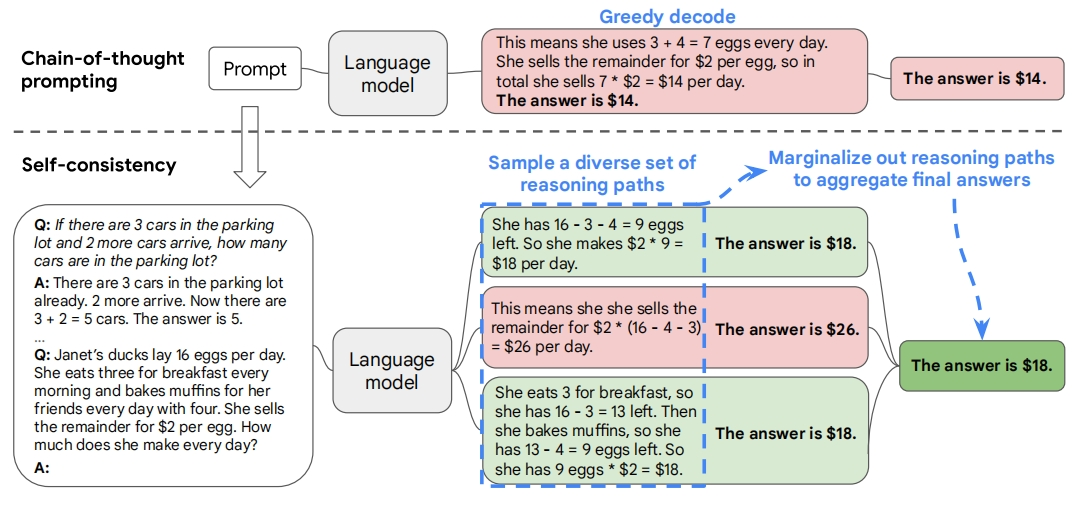

**自我一致性扩展了思维链的构建，它能生成多个思维链，而不仅仅是一个，并通过多数投票选择最终答案。** 自我一致性策略利用了这样一种理念，即一个复杂的推理问题通常可以通过多种不同的思维方式得出同一个正确答案。具体实现是通过少样本 CoT 采样多个不同的推理路径，并从生成结果中选择最一致的答案。


In [10]:
# 改造一下获得 Completions 的函数  设置参数 n=3，temperature=0.80，实现生成多个不尽相同的思维链

def get_completions(system_instruction, llm_prompt, model_endpoint):

    response = client.chat.completions.create(model=model_endpoint,
                                              messages=[{"role": "system", "content": system_instruction},
                                                        {"role": "user", "content": llm_prompt}
                                                       ],
                                              n=3, temperature=0.80, seed=42,
                                              presence_penalty=0, frequency_penalty=0,
                                              max_tokens=1024
                                             )

    return response.choices, response.usage

In [11]:
llm = "gpt-3.5-turbo-0125"

system_instruction = "您是世界知识专家。"

# Few-shot 思维链提示过程
prompt = f"""问：罗杰有 5 个网球。他又买了 2 罐网球。每罐有 3 个网球。他现在有多少个网球？
答：罗杰开始有 5 个球。每罐有 3 个网球，两罐共有 6 个网球。5 + 6 = 11。答案是 11。
问：森林中开始有 15 棵树。林业工人今天将在林中种树。完成后，将有 21 棵树。林业工人今天种了多少棵树？
答：我们从 15 棵树开始。后来我们有 21 棵树。差异必须是他们种树的数量。因此，他们必须种了 21 - 15 = 6 棵树。答案是 6。
问：杰克有 23 美元。他以每个 3 美元的价格买了 5 个小蛋糕。他还剩下多少钱？
答：他以每个 3 美元的价格买了 5 个小蛋糕，总共花费了 3 * 5 = 15 美元。所以，他还剩下 23 - 15 = 8 美元。答案是 8 美元。
问：当我 6 岁时，我的妹妹的年龄是我的一半。现在我已经 24 岁了，那么我的妹妹现在的年龄是多少？
答：当你 6 岁时，你妹妹的年龄是 6 / 2 = 3 岁。现在你 24 岁，所以你妹妹的年龄是 24 - (6 - 3) = 21 岁。
问：李莉的鸭子每天下 16 个蛋。她每天早餐吃 3 个，每天用 4 个给朋友烤松饼。剩下的蛋她以每个 2 美元的价格出售。她每天能赚多少钱？
答：
"""

result_Chinese, tokens_count = get_completions(system_instruction, prompt, llm)
for response_num, con in enumerate(result_Chinese, start=1):
    result = con.message.content.strip()
    print(f"思维链-中文-{response_num}：\n{result}\n")

思维链-中文-1：
每天鸭子下 16 个蛋，李莉每天早餐吃 3 个，每天用 4 个给朋友烤松饼，所以她每天剩下 16 - 3 - 4 = 9 个蛋。她以每个 2 美元的价格出售，所以她每天能赚 9 * 2 = 18 美元。答案是 18 美元。

思维链-中文-2：
李莉的鸭子每天下 16 个蛋。她每天早餐吃 3 个，每天用 4 个给朋友烤松饼，剩下的蛋她以每个 2 美元的价格出售。

剩下的蛋数量为 16 - 3 - 4 = 9 个。

她以每个 2 美元的价格出售这 9 个蛋，所以她每天能赚取的金额为 9 * 2 = 18 美元。所以，她每天能赚 18 美元。

思维链-中文-3：
首先，李莉的鸭子每天下 16 个蛋。她每天早餐吃 3 个，每天用 4 个给朋友烤松饼，所以每天剩下 16 - 3 - 4 = 9 个蛋。她以每个 2 美元的价格出售蛋，所以每天能赚 9 * 2 = 18 美元。李莉每天能赚 18 美元。



In [12]:
llm = "gpt-3.5-turbo-0125"

system_instruction = "You are an expert at world knowledge."

prompt = f"""Q: Roger has 5 tennis balls. He bought 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger starts with 5 balls. With 3 tennis balls in each can, there are 6 tennis balls in the two cans. 5 + 6 = 11. The answer is 11.
Q: There are 15 trees in the forest to begin with. Forest workers will plant trees in the forest today. When finished, there will be 21 trees. How many trees did the foresters plant today?
A: We started with 15 trees. Later we had 21 trees. The difference must be the number of trees they planted. Therefore, they must have planted 21 - 15 = 6 trees. The answer is 6.
Q: Jack has 23 dollars. He bought 5 cupcakes for $3 each. How much money does he have left?
A: He bought 5 cupcakes for $3 each and spent a total of 3 * 5 = $15. So, he has 23 - 15 = $8 left. The answer is $8.
Q: When I was 6 years old, my sister was half my age. Now that I am 24 years old, what is my sister's age now?
A: When you were 6 years old, your sister was 6 / 2 = 3 years old. Now you are 24, so your sister's age is 24 - (6 - 3) = 21.
Q: Lily's duck lays 16 eggs a day. She eats 3 each day for breakfast and uses 4 each day to bake muffins for her friends. She sells the remaining eggs for $2 each. How much money does she make each day?
A: 
"""

result_English, tokens_count = get_completions(system_instruction, prompt, llm)
for response_num, con in enumerate(result_English, start=1):
    result = con.message.content.strip()
    print(f"思维链-英文-{response_num}：\n{result}\n")

思维链-英文-1：
To calculate how much money Lily makes each day, we first need to determine how many eggs are left after she uses some for breakfast and baking:

Total eggs laid per day: 16
Eggs eaten for breakfast: 3
Eggs used for baking: 4

Remaining eggs: 16 - 3 - 4 = 9

Now, we can calculate how much money Lily makes by selling the remaining eggs:

Number of eggs sold: 9
Price per egg: $2

Total money made: 9 * 2 = $18

Therefore, Lily makes $18 each day by selling the remaining eggs.

思维链-英文-2：
To calculate how much money Lily makes each day, we first need to determine how many eggs she has left after using some for breakfast and baking muffins.

If the duck lays 16 eggs a day and Lily uses 3 for breakfast and 4 for baking muffins, she uses a total of 3 + 4 = 7 eggs.

So, the number of eggs remaining for sale is 16 - 7 = 9 eggs.

If she sells each egg for $2, then her daily earnings from selling eggs is 9 * $2 = $18.

Therefore, Lily makes $18 each day from selling the remaining eggs.



## 三、总结与讨论
***

要点总结：
- **思维链**（Chain-of-Thought，CoT）的本质是一种离散式提示学习。通过生成一系列中间推理步骤，以提高大语言模型执行复杂推理的能力。

- 当获取思维链提示的示例较少或存在困难时，**零样本思维链**可以发挥作用。然而，它有时候不如思维链提示过程那么有效。由于提取步骤通常需要针对特定任务，因此零样本思维链的泛化能力并不是那么强。

- **自我一致性**扩展了思维链的构建，它生成多个思维链，并通过多数投票选择最终答案。 自我一致性策略利用了这样一种理念，即一个复杂的推理问题通常可以通过多种不同的思维方式得出同一个正确答案。这种方法通常具有良好的性能。研究发现，自我一致性也能提升在算术、常识和符号推理任务上的表现。即使原始的思维链无效，自我一致性也能改善结果。


📚 主要参考资料：
- NeurIPS 2020 - Language Models are Few-Shot Learners，https://arxiv.org/abs/2005.14165

- NeurIPS 2022 - Chain-of-Thought Prompting Elicits Reasoning in Large Language Models，https://openreview.net/forum?id=_VjQlMeSB_J

- NeurIPS 2022 - Large Language Models are Zero-Shot Reasoners，https://openreview.net/forum?id=e2TBb5y0yFf

- ICLR 2023 - Self-Consistency Improves Chain of Thought Reasoning in Language Models，https://arxiv.org/abs/2203.11171

- 哈工大 & 华为团队发布的思维链推理综述，A Survey of Chain of Thought Reasoning: Advances, Frontiers and Future，https://arxiv.org/abs/2309.15402